Importing necessary tools

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud

# EDA

In [2]:
df = pd.read_csv('../data/raw/train.csv')
df['sentiment'].value_counts(normalize=True)

sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64

The train dataset is balanced.

In [3]:
df.head()

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative


In [4]:
df.shape

(40000, 2)

In [5]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

No missing values.

Need to apply some data preprocessing for EDA to ensure consistency.

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_review(review):
    review = review.lower()  # lowercasing
    review = re.sub(r'<.*?>', '', review)  # removes HTML
    review = re.sub(r'[^a-z\s]', '', review)  # remove punctuation/numbers
    tokens = word_tokenize(review)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # using lemmatizer just for EDA
    return ' '.join(tokens)

df['clean_review'] = df['review'].apply(clean_review)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Triston\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Triston\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Triston\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Triston\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Triston\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [7]:
df['clean_review'].head()

0    caught little gem totally accident back reviva...
1    cant believe let movie accomplish favor friend...
2    spoiler alert get nerve people remake use term...
3    there one thing ive learnt watching george rom...
4    remember theater review said horrible well did...
Name: clean_review, dtype: object

Investigating in word count of each review for each sentiment.

In [8]:
PLOT_DIR = os.path.dirname(os.getcwd()) + '/outputs/figures'

def save_fig(fig_name):
    """helper function to save a figure"""
    if not os.path.exists(PLOT_DIR):
        os.makedirs(PLOT_DIR)
    save_path = os.path.join(PLOT_DIR, fig_name)
    plt.savefig(save_path, format='jpg', dpi=300)

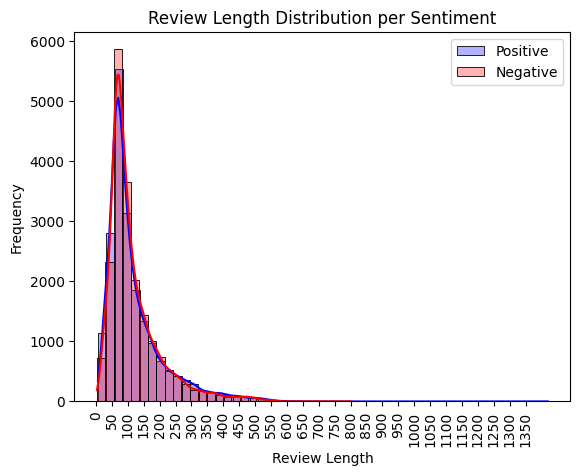

In [9]:
pos_sent = df[df['sentiment'] == 'positive']['clean_review']
neg_sent = df[df['sentiment'] == 'negative']['clean_review']
pos_sent_word_count = pos_sent.str.split().str.len()
neg_sent_word_count = neg_sent.str.split().str.len()
sns.histplot(pos_sent_word_count, color='blue', label='Positive', kde=True, bins=54, alpha=0.3)
sns.histplot(neg_sent_word_count, color='red', label='Negative', kde=True, bins=30, alpha=0.3)
plt.title('Review Length Distribution per Sentiment')
plt.xlabel('Review Length')
plt.xticks(np.arange(0, 1400, 50), rotation=90)
plt.ylabel('Frequency')
plt.legend()
save_fig(fig_name='review_length_distribution_per_sentiment.jpg')
plt.show()

It can be seen that most of the reviews consist of 50-100 words. Though positive sentiment reviews have some really long poems.

Let's see which words are the most common.

In [10]:
pos_sent_word_count = ' '.join(pos_sent).split()
neg_sent_word_count = ' '.join(neg_sent).split()
pos_word_freq = Counter(pos_sent_word_count)
neg_word_freq = Counter(neg_sent_word_count)
print('Positive sentiment most common words:', pos_word_freq.most_common(20))
print('Negative sentiment most common words:', neg_word_freq.most_common(20))

Positive sentiment most common words: [('film', 38556), ('movie', 34452), ('one', 21628), ('like', 13854), ('time', 12169), ('good', 11535), ('character', 10920), ('story', 10872), ('great', 10089), ('see', 10011), ('get', 8887), ('well', 8814), ('make', 8745), ('really', 8549), ('also', 8515), ('would', 8260), ('scene', 7778), ('show', 7504), ('even', 7449), ('life', 7310)]
Negative sentiment most common words: [('movie', 44846), ('film', 33625), ('one', 20634), ('like', 17819), ('even', 11917), ('good', 11383), ('time', 11369), ('bad', 11369), ('character', 11235), ('would', 10978), ('get', 10587), ('make', 10051), ('really', 9834), ('scene', 8863), ('see', 8819), ('story', 8479), ('dont', 8029), ('much', 7845), ('people', 7391), ('thing', 7325)]


Most common words are almost the same in both sentiments, even "good" occurs with the same frequency. However, "bad" is present in top 20 in negative sentiment but is not in positive one. This can make classification easier.

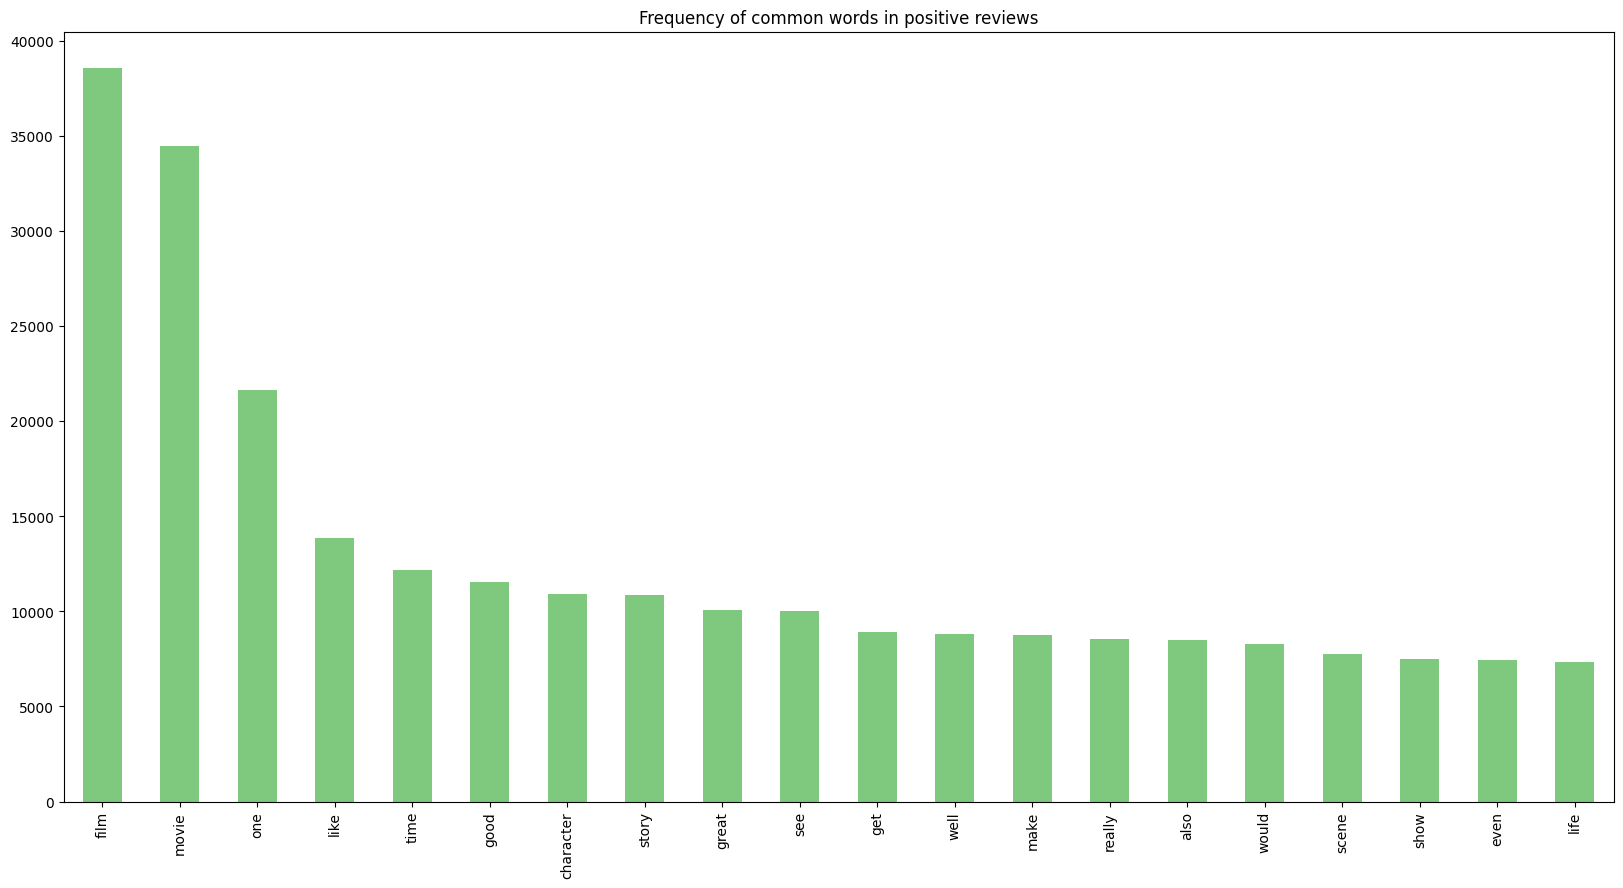

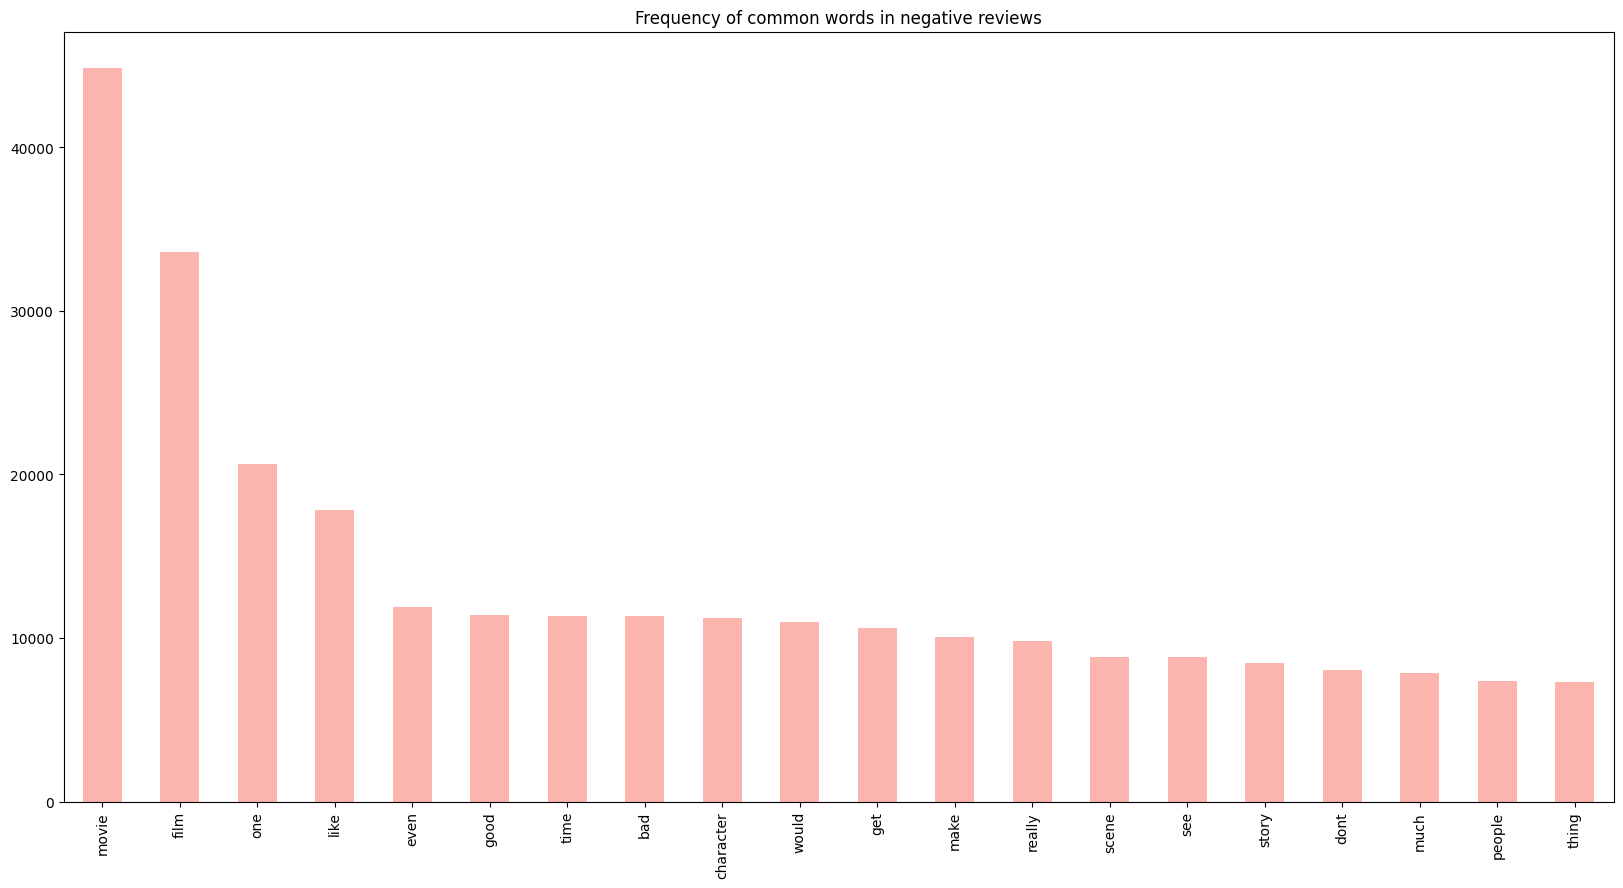

In [11]:
colors = ['Accent','Pastel1']
data = [pos_sent, neg_sent]
labels = ['positive','negative']
fignames = 'common_pos.jpg common_neg.jpg'.split()
for item in range(2):
    plt.figure(figsize=(20,10))
    pd.Series(' '.join([i for i in data[item]]).split()).value_counts().head(20).plot(kind='bar',colormap=colors[item])
    plt.title(f"Frequency of common words in {labels[item]} reviews")
    save_fig(fignames[item])
    plt.show()

The words "movie", "film" and "one" are repeated very frequently but have nothing to do with sentiment so I'll remove them for better performance.

In [12]:
words_del = 'movie film one make would'.split()
def remove_freq_words(review:str):
    return ' '.join([i for i in review.split() if i not in words_del])
df['clean_review'] = df['clean_review'].apply(lambda text: remove_freq_words(text))

Let's see what are the most used bi-grams.

In [13]:
pos_sent = df[df['sentiment'] == 'positive']['clean_review']
neg_sent = df[df['sentiment'] == 'negative']['clean_review']
vectorizer = CountVectorizer(ngram_range=(2, 2))
pos_bigrams = vectorizer.fit_transform(pos_sent)
neg_bigrams = vectorizer.fit_transform(neg_sent)
pos_bigram_freq = dict(zip(vectorizer.get_feature_names_out(), pos_bigrams.sum(axis=0).tolist()[0]))
neg_bigram_freq = dict(zip(vectorizer.get_feature_names_out(), neg_bigrams.sum(axis=0).tolist()[0]))
# Sort and display top 10 bigrams
pos_sorted_bigrams = sorted(pos_bigram_freq.items(), key=lambda x: x[1], reverse=True)[:10]
neg_sorted_bigrams = sorted(neg_bigram_freq.items(), key=lambda x: x[1], reverse=True)[:10]
print("Positive bigrams:", pos_sorted_bigrams)
print("Negative bigrams:", neg_sorted_bigrams)

Positive bigrams: [('lap finally', 868), ('eye especially', 793), ('fact cruder', 743), ('fun watchif', 719), ('early jerry', 682), ('missed making', 669), ('part carefully', 665), ('talking whining', 616), ('meanwhile karen', 596), ('early turkish', 466)]
Negative bigrams: [('look like', 1746), ('ever seen', 1285), ('special effect', 1146), ('waste time', 1095), ('dont know', 952), ('ive seen', 896), ('main character', 863), ('much better', 782), ('worst ever', 754), ('year old', 731)]


It can be seen that negative sentiments have words like "waste time", "worst ever". It also can help with distinguishing.

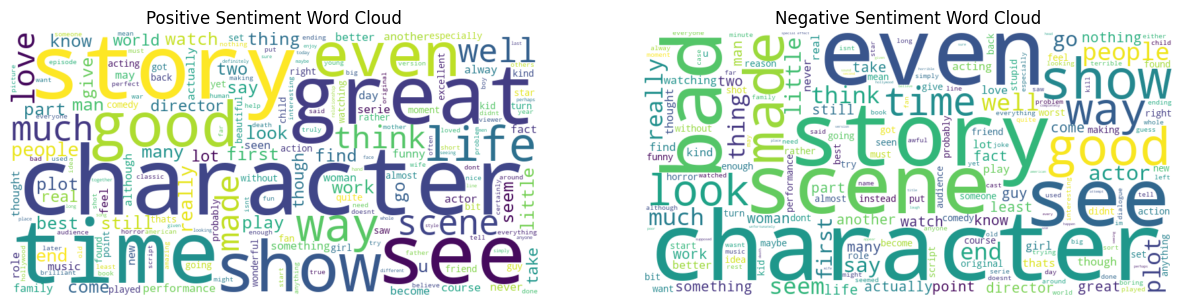

In [14]:
pos_sent_str = ' '.join(pos_sent.astype(str))
neg_sent_str = ' '.join(neg_sent.astype(str))

positive_wc = WordCloud(width=800, height=400, background_color='white').generate(pos_sent_str)
negative_wc = WordCloud(width=800, height=400, background_color='white').generate(neg_sent_str)

plt.figure(figsize=(15, 7.5))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')
save_fig(fig_name='word_clouds.jpg')
plt.show()

Most of the words occur in roughly same amount in both positive and negative sentiments ("character", "story", "scene", even the word "good"). But there are some words which are present only in one cloud (positive: "brilliant", "excellent", "interesting", "wonderful"; negative: "poor", "boring", "awfull").

# Data preprocessing

## Stemming vs Lemmatization

In [15]:
stemmer = PorterStemmer()

def clean_review_stemming(review):
    review = review.lower()  # lowercasing
    review = re.sub(r'<.*?>', '', review)  # removes html
    review = re.sub(r'[^a-z\s]', '', review)  # remove punctuation, numbers
    tokens = word_tokenize(review)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [16]:
df['clean_review_stemming'] = df['review'].apply(clean_review_stemming)

In [17]:
df['clean_review_stemming'].head()

0    caught littl gem total accid back reviv theatr...
1    cant believ let movi accomplish favor friend a...
2    spoiler alert get nerv peopl remak use term lo...
3    there one thing ive learnt watch georg romero ...
4    rememb theater review said horribl well didnt ...
Name: clean_review_stemming, dtype: object

Stemming reduced the words to their root form by chopping off the suffixes (movie -> movi).

Lemmatizing requires POS tagging for better results.

In [18]:
def get_wordnet_pos(treebank_tag):
    """function to convert POS tagging to wordnet format"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [19]:
def clean_review_lemma(review):
    review = review.lower()
    review = re.sub(r'<.*?>', '', review)
    review = re.sub(r'[^a-z\s]', '', review)
    tokens = word_tokenize(review)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tags]
    return ' '.join(lemmatized_tokens)

In [20]:
df['clean_review_lemma'] = df['review'].apply(clean_review_lemma)
df.head()

,review,sentiment,clean_review,clean_review_stemming,clean_review_lemma
0,I caught this little gem totally by accident b...,positive,caught little gem totally accident back reviva...,caught littl gem total accid back reviv theatr...,i catch this little gem totally by accident ba...
1,I can't believe that I let myself into this mo...,negative,cant believe let accomplish favor friend ask e...,cant believ let movi accomplish favor friend a...,i cant believe that i let myself into this mov...
2,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert get nerve people remake use term...,spoiler alert get nerv peopl remak use term lo...,spoiler alert it just get to me the nerve some...
3,If there's one thing I've learnt from watching...,negative,there thing ive learnt watching george romeros...,there one thing ive learnt watch georg romero ...,if there one thing ive learnt from watch georg...
4,"I remember when this was in theaters, reviews ...",negative,remember theater review said horrible well did...,rememb theater review said horribl well didnt ...,i remember when this be in theater review say ...


Lemmatizer converted the words to their base form, by getting rid of tense with the help of dictionary.

And there is difference of lemmatization with and without POS tagging can be seen from the first review: "caught" vs "catch".

## Stop words removing

Stop words do not carry a lot of information, so it is better to remove them.

In [21]:
def stop_words_removal(review):
    tokens = word_tokenize(review)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [22]:
df['clean_review_lemma'] = df['clean_review_lemma'].apply(stop_words_removal)
df['clean_review_lemma'].head()

0    catch little gem totally accident back revival...
1    cant believe let movie accomplish favor friend...
2    spoiler alert get nerve people remake use term...
3    one thing ive learnt watch george romeros cree...
4    remember theater review say horrible well didn...
Name: clean_review_lemma, dtype: object

The function removed words such as: "i", "this", "myself", etc.

## Vectorization

I'm going to use bag-of-words with TF-IDF and n-grams with TF-IDF.

TF-IDF gives more weight to more frequent words.

I'll try to find best combination out ot bag-of-words, n-grams, stemming, lemmatization.

In [23]:
# with stemming
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review_stemming'],
    df['sentiment'],
    test_size=0.2,
    shuffle=True,
    random_state=42
    )

C:\Users\Triston\AppData\Local\Temp\ipykernel_18508\3233078169.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})


Here I'll also compare unigrams and bigrams.

In [24]:
unigram_vec = TfidfVectorizer(max_features = 7000)  # takes 7000 most frequent words
X_train_unigram = unigram_vec.fit_transform(X_train).toarray()
X_test_unigram = unigram_vec.transform(X_test).toarray()

Logistig regression for baseline model.

In [25]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train_unigram, y_train)
predictions = model.predict(X_test_unigram)
logistic_regression_accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy * 100:.2f}%")
print("Classification Report:\n", report)

Logistic Regression Accuracy: 87.98%
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3984
           1       0.87      0.89      0.88      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



Pretty impressive performance for baseline model.

I'll do the same process but for lemmatized reviews.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review_lemma'],
    df['sentiment'],
    test_size=0.2,
    shuffle=True,
    random_state=42
    )
unigram_vec = TfidfVectorizer(max_features = 7000)
X_train_unigram = unigram_vec.fit_transform(X_train).toarray()
X_test_unigram = unigram_vec.transform(X_test).toarray()
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train_unigram, y_train)
predictions = model.predict(X_test_unigram)
logistic_regression_accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy * 100:.2f}%")
print("Classification Report:\n", report)

Logistic Regression Accuracy: 87.94%
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3984
           1       0.87      0.89      0.88      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



Almost same results as with lemmatization. From now on I'll stick with lemmatization, because it seems reasonable not to cut off words and make them meaningless.

Testing out bigrams.

In [27]:
bigram_vec = TfidfVectorizer(max_features=7000, ngram_range=(2,2))
X_train_bigram = bigram_vec.fit_transform(X_train).toarray()
X_test_bigram = bigram_vec.transform(X_test).toarray()

model1 = LogisticRegression(random_state=42, solver='liblinear')
model1.fit(X_train_bigram, y_train)
predictions = model1.predict(X_test_bigram)
logistic_regression_accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy * 100:.2f}%")
print("Classification Report:\n", report)

Logistic Regression Accuracy: 82.45%
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      3984
           1       0.82      0.84      0.83      4016

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000



TF-IDF vectorization along with BOW as unigrams overperfomed bigram ones and this is logical because importance of every word is more essential than the relationship between words in this sentiment analysis.

# Modelling

I'll try out 3 models:
* Logistig Regression as baseline model
* Random Forest Classifier
* SVC

## Logistic Regression

In [28]:
#penalizing with ridge and lasso 
log_cls = LogisticRegression(random_state=42, solver='liblinear')
param_grid = {
   'penalty': ['l1', 'l2']    
}

grid_search = GridSearchCV(
    estimator=log_cls,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
    )

grid_search.fit(X_train_unigram, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_logistic_regression_model = grid_search.best_estimator_
y_pred = best_logistic_regression_model.predict(X_test_unigram)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test,y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)

Best Hyperparameters: {'penalty': 'l2'}
Logistic Regression Accuracy: 87.94%
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3984
           1       0.87      0.89      0.88      4016

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



Regularization did not improve the accuracy of the model.

## Random Forest Classifier

In [29]:
rfcls = RandomForestClassifier(n_jobs=-1, verbose=1, random_state=42, n_estimators=100, max_depth=20)
rfcls.fit(X_train_bigram, y_train)
predictions = rfcls.predict(X_test_bigram)
rf_acc = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"RF Model accuracy: {rf_acc * 100:.2f}%")
print("Classification Report:\n", report)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


RF Model accuracy: 72.29%
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.57      0.67      3984
           1       0.67      0.88      0.76      4016

    accuracy                           0.72      8000
   macro avg       0.75      0.72      0.72      8000
weighted avg       0.75      0.72      0.72      8000



Random forest classifier performed poorly for sentiment analysis.

## SVC

In [30]:
svc = SVC(random_state=42, kernel='linear', max_iter=1000)
svc.fit(X_train_bigram, y_train)
predictions = svc.predict(X_test_bigram)
svc_acc = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"SVC Model accuracy: {svc_acc * 100:.2f}%")
print("Classification Report:\n", report)

c:\Users\Triston\anaconda3\envs\module_4_trees\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC Model accuracy: 66.19%
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      3984
           1       0.67      0.64      0.65      4016

    accuracy                           0.66      8000
   macro avg       0.66      0.66      0.66      8000
weighted avg       0.66      0.66      0.66      8000



SVC performed even worse, the possible reasons may be that I've set the kernel to linear and max_iter=1000, but due to time limits can not change them.

So, we have the winner, which is logistic regression with ~88% accuracy, decent.